In [20]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [21]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [22]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [24]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[6],
        [4],
        [6],
        [4],
        [4],
        [4],
        [5],
        [4],
        [6],
        [4]])


In [25]:
equals = top_class == labels.view(*top_class.shape)

In [17]:
equals.shape

torch.Size([64, 1])

In [26]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


In [29]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        

Epoch: 1/30..  Training Loss: 0.517..  Test Loss: 0.505..  Test Accuracy: 0.826
Epoch: 2/30..  Training Loss: 0.392..  Test Loss: 0.431..  Test Accuracy: 0.849
Epoch: 3/30..  Training Loss: 0.357..  Test Loss: 0.386..  Test Accuracy: 0.866
Epoch: 4/30..  Training Loss: 0.330..  Test Loss: 0.374..  Test Accuracy: 0.870
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.366..  Test Accuracy: 0.867
Epoch: 6/30..  Training Loss: 0.302..  Test Loss: 0.377..  Test Accuracy: 0.870
Epoch: 7/30..  Training Loss: 0.289..  Test Loss: 0.379..  Test Accuracy: 0.872
Epoch: 8/30..  Training Loss: 0.280..  Test Loss: 0.375..  Test Accuracy: 0.873
Epoch: 9/30..  Training Loss: 0.275..  Test Loss: 0.369..  Test Accuracy: 0.876
Epoch: 10/30..  Training Loss: 0.265..  Test Loss: 0.358..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.257..  Test Loss: 0.389..  Test Accuracy: 0.868
Epoch: 12/30..  Training Loss: 0.255..  Test Loss: 0.380..  Test Accuracy: 0.871
Epoch: 13/30..  Training Loss: 0.249.

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

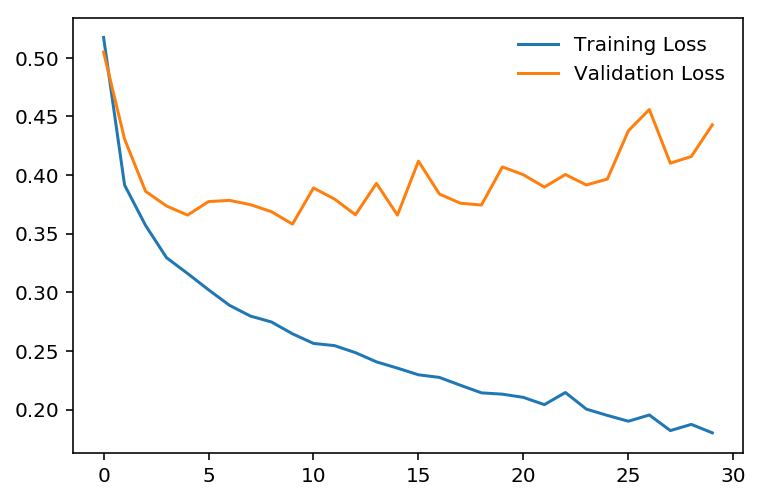

In [32]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label = 'Validation Loss')

plt.legend(frameon=False)

# Overfitting

In [33]:
#DropOut

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
        #Dropout module with 0.2 drop probabiltiy
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        #make sure input is flattened
        x = x.view(x.shape[0], -1)
        
        #Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        #Output so no drop out
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    

In [36]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.602..  Test Loss: 0.470..  Test Accuracy: 0.823
Epoch: 2/30..  Training Loss: 0.482..  Test Loss: 0.422..  Test Accuracy: 0.845
Epoch: 3/30..  Training Loss: 0.453..  Test Loss: 0.410..  Test Accuracy: 0.851
Epoch: 4/30..  Training Loss: 0.430..  Test Loss: 0.424..  Test Accuracy: 0.849
Epoch: 5/30..  Training Loss: 0.425..  Test Loss: 0.444..  Test Accuracy: 0.841
Epoch: 6/30..  Training Loss: 0.413..  Test Loss: 0.399..  Test Accuracy: 0.858
Epoch: 7/30..  Training Loss: 0.404..  Test Loss: 0.394..  Test Accuracy: 0.861
Epoch: 8/30..  Training Loss: 0.400..  Test Loss: 0.386..  Test Accuracy: 0.859
Epoch: 9/30..  Training Loss: 0.385..  Test Loss: 0.412..  Test Accuracy: 0.858
Epoch: 10/30..  Training Loss: 0.387..  Test Loss: 0.381..  Test Accuracy: 0.867
Epoch: 11/30..  Training Loss: 0.379..  Test Loss: 0.393..  Test Accuracy: 0.863
Epoch: 12/30..  Training Loss: 0.377..  Test Loss: 0.386..  Test Accuracy: 0.869
Epoch: 13/30..  Training Loss: 0.378.

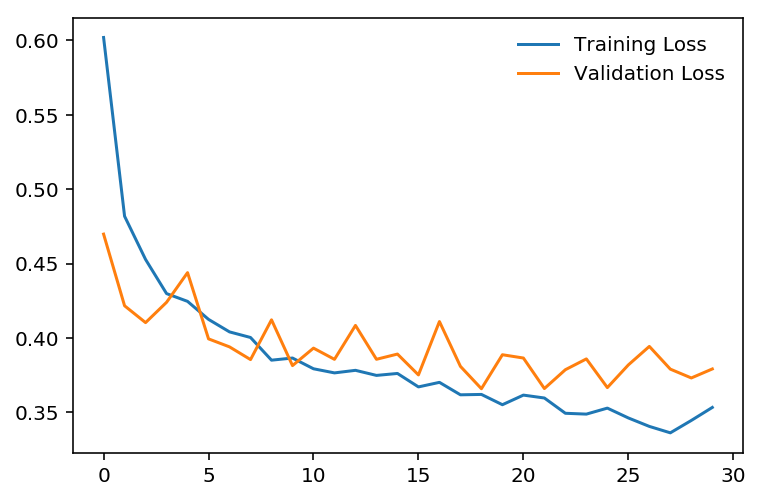

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.legend(frameon=False)

## Inference

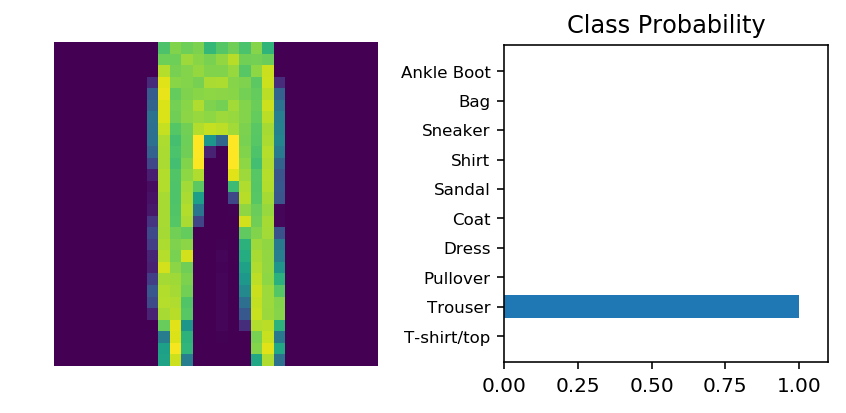

In [41]:
import helper

#Test out network

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()

img = images[0]

#Convert 2D images to 1D vector

img = img.view(1, 784)

#Calculate the class probablities
with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)

helper.view_classify(img.view(1,28,28), ps, version = 'Fashion')